# City on the Move: Insights from New York's Yellow Cabs 🚕 🇺🇸
# Case Study for LYNX BERLIN 
### by Anahit Babayan
#### Table of Contents
- [1) Data Loading, Cleanup & Feature Engineering](#data-cleanup)
    - [a) Handling Missing Values](#null)
    - [b) Feature Engineering](#engin)
- [2) Data Analysis, Descriptive Statistics](#analysis)
- [3) 2023 Forecast](#forecast)
    - [a) Forecast on revenue growth 2023](#revenue)
    - [b) Seasonality](#seasonality)
    - [c) Happy Tips, perhaps?](#tips)
- [4) Management Summary](#summary)

### <a name="data-cleanup"></a>1) Data Loading, Cleanup & Feature Engineering

In [808]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

In [810]:
data=pd.read_csv('Yellow_Taxi_Assignment.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


### <a name="null"></a>a) Handling Missing Values

In [813]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               304978 non-null  int64  
 1   tpep_pickup_datetime   304978 non-null  object 
 2   tpep_dropoff_datetime  304978 non-null  object 
 3   passenger_count        295465 non-null  float64
 4   trip_distance          304978 non-null  float64
 5   RatecodeID             295465 non-null  float64
 6   store_and_fwd_flag     295465 non-null  object 
 7   PULocationID           304978 non-null  int64  
 8   DOLocationID           304978 non-null  int64  
 9   payment_type           304978 non-null  int64  
 10  fare_amount            304978 non-null  float64
 11  extra                  304978 non-null  float64
 12  mta_tax                304978 non-null  float64
 13  tip_amount             304978 non-null  float64
 14  tolls_amount           304978 non-nu

We have 19 columns in total and 304978 rows. The null values are present in the fields such as passenger_count, RatecodeID, store_and_fwd_flag,congestion_surcharge and airport_fee. In order to understand the correct way to proceed I did a research and tried to understand what each field means and how to treat null values: 
- passenger_count: The number of passengers during the trip (may include missing or erroneous data if drivers didn’t record it properly).
- RatecodeID: Codes for the rate type applied to the trip (e.g., 1 for standard fare, 2 for JFK, 3 for Newark, etc.).
- store_and_fwd_flag: Indicates whether the trip data was stored and forwarded because the vehicle was out of communication range (e.g., "Y" for yes, "N" for no).
- congestion_surcharge: Additional fee during peak traffic hours (e.g., $2.50 introduced in recent years).
- airport_fee: Fixed fee applied to trips involving certain airport zones (e.g., JFK or Newark).

Stored and forwarded flag includes either 'Yes' or 'No', thus the decision was made to flag the null values as well, as 'Unknown'. In this case,we won't lose any data where the flag of being stored and forwarded would be 'Unknown'.

In [817]:
data['store_and_fwd_flag'].fillna('Unknown', inplace=True)

For passenger count, assumption is that there can't be 0 number of passengers as well as 6, since there are 5 seats including driver's.

In [820]:
print(data['passenger_count'].describe())
print(data['passenger_count'].value_counts())

count    295465.000000
mean          1.479126
std           1.108255
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64
passenger_count
1.0    214927
2.0     43436
3.0     11642
5.0      8979
6.0      5813
0.0      5535
4.0      5133
Name: count, dtype: int64


We will fill in NAs with mode, as it is the safest choice for passenger_count. However, not only do we fill in NAs but also outlier values such as 0s and 6s.

In [823]:
passenger_count_mode = data['passenger_count'].mode()[0]

data['passenger_count'] = data['passenger_count'].apply(
    lambda x: passenger_count_mode if pd.isnull(x) or x <= 0 or x >= 6 else x
)

Let's extract the data when RatecodeID is missing and look at key columns such as trip_distance and fare_amount for rows with missing RatecodeID.


In [826]:
missing_ratecode_rows = data[data['RatecodeID'].isnull()]

missing_ratecode_details = missing_ratecode_rows[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'store_and_fwd_flag', 'passenger_count']]

missing_ratecode_details.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,store_and_fwd_flag,passenger_count
37873,2018-08-18 14:08:00,2018-08-18 14:35:00,8.75,33.69,Unknown,1.0
40860,2018-09-06 13:00:00,2018-09-06 13:42:00,7.10,28.95,Unknown,1.0
41315,2018-09-09 13:13:00,2018-09-09 13:41:00,6.02,28.95,Unknown,1.0
42130,2018-09-14 10:32:00,2018-09-14 11:11:00,4.29,25.45,Unknown,1.0
42676,2018-09-17 10:20:00,2018-09-17 10:50:00,4.36,28.95,Unknown,1.0


Immediately, it is seen that when RatecodeID is null than the store_and_fwd_flag are null. This could be indicative of incomplete or problematic data entries. However, this is the data and we should find a way to clean it.
Calculate the average trip_distance and fare_amount for each RatecodeID

In [829]:
ratecode_avg = data.groupby('RatecodeID')[['trip_distance', 'fare_amount']].mean()
print(ratecode_avg)

            trip_distance  fare_amount
RatecodeID                            
1.0              2.601129    11.686628
2.0             16.871601    51.627089
3.0             16.060016    64.181159
4.0             18.651063    68.032558
5.0              5.546092    56.773124
6.0              0.000000     2.500000
99.0             6.199851    33.537127


In [831]:
# Define the function to replace RatecodeID based on trip_distance and fare_amount
def replace_ratecode(row):
    if pd.isnull(row['RatecodeID']):
        if 16.0 <= row['trip_distance'] <= 17.5 and 50 <= row['fare_amount'] <= 54:
            return 2  # Airport trip (JFK)
        elif 15.0 <= row['trip_distance'] <= 16.5 and 62 <= row['fare_amount'] <= 66:
            return 3  # Airport trip (Newark)
        elif 18.0 <= row['trip_distance'] <= 19.5 and 66 <= row['fare_amount'] <= 70:
            return 4  # Longer trip
        elif 5.0 <= row['trip_distance'] <= 6.5 and 54 <= row['fare_amount'] <= 58:
            return 5  # Other specific rate
        elif row['trip_distance'] <= 0.5 and row['fare_amount'] <= 3:
            return 6  # Surcharge fee, maybe cancellation fee?
        elif 6.0 <= row['trip_distance'] <= 7.0 and 30 <= row['fare_amount'] <= 35:
            return 99  # Rare rate, maybe an outlier
        else:
            return 0  # Placeholder for unmatched cases
    return row['RatecodeID']
# Apply the function to replace missing RatecodeID values
data['RatecodeID'] = data.apply(replace_ratecode, axis=1)

These two fields are numeric but also categorical(in a way) and if the values for them are missing then it was'nt airport trip/surcharge.
Hence, we treat nulls as 0s here.

In [833]:
data['airport_fee'].fillna(0, inplace=True)
data['congestion_surcharge'].fillna(0, inplace=True)

In [836]:
#Check whether we have missing values left.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               304978 non-null  int64  
 1   tpep_pickup_datetime   304978 non-null  object 
 2   tpep_dropoff_datetime  304978 non-null  object 
 3   passenger_count        304978 non-null  float64
 4   trip_distance          304978 non-null  float64
 5   RatecodeID             304978 non-null  float64
 6   store_and_fwd_flag     304978 non-null  object 
 7   PULocationID           304978 non-null  int64  
 8   DOLocationID           304978 non-null  int64  
 9   payment_type           304978 non-null  int64  
 10  fare_amount            304978 non-null  float64
 11  extra                  304978 non-null  float64
 12  mta_tax                304978 non-null  float64
 13  tip_amount             304978 non-null  float64
 14  tolls_amount           304978 non-nu

### <a name="engin"></a>b) Feature Engineering

Conversion of pickup/dropoff datetime from string to datetime

In [840]:
#  We have two dates that are provided as strings, let's convert datetime columns to proper datetime format
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')

Calculation of trip duration in minutes

In [843]:
# Let's create a new field for trip duration in minutes
data['trip_duration_minutes'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

Extraction of the hours of the day

In [846]:
# It is also plausable to have the hour of pick up to identify trends or so said "busy hours".
data['hour_of_day'] = data['tpep_pickup_datetime'].dt.hour

Extraction of the days of the week

In [849]:
# Interesting to know also the day of the week of pick up to see whether Mondays are busy or maybe Fridays.
data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek  
# It's flagged starting from Monday=0 and ending with Sunday=6

Weekend flag

In [852]:
# We can also get a flag whether it was a weekend or not
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

Extraction of the months of the year

In [855]:
# For capturing seasonality we can extract months as well
data['month_of_year'] = data['tpep_pickup_datetime'].dt.month

Calculation of fare per mile

In [858]:
# It is also crucial to know the fare per mile 
data['fare_per_mile'] = data['fare_amount'] / data['trip_distance']

Calculation of tip percentage

In [861]:
# Tips are huge in US, so it would be important to take a look at the tip percentages (shares)
data['tip_percentage'] = (data['tip_amount'] / data['fare_amount']) * 100

Calculation of total surcharge

In [864]:
# We have multiple surcharges, thus it would be useful to have the total surcharge as well.
data['total_surcharge'] = data['congestion_surcharge'] + data['airport_fee'] + data['improvement_surcharge']

Calculation of traffic indicator

In [867]:
# It is possible to capture traffic indicator as well since we have congestion_surcharge
data['traffic_indicator'] = (data['congestion_surcharge'] > 0).astype(int)

In [869]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,hour_of_day,day_of_week,is_weekend,month_of_year,fare_per_mile,tip_percentage,total_surcharge,traffic_indicator
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,0.0,0.0,2.066667,12,0,0,1,6.603774,36.857143,0.3,0
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,0.0,0.0,4.683333,12,0,0,1,5.714286,17.000000,0.3,0
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,0.0,0.0,11.066667,1,0,0,1,5.191257,17.052632,0.3,0
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,0.0,0.0,9.766667,8,0,0,1,4.347826,0.000000,0.3,0
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,0.0,0.0,13.950000,1,0,0,1,4.084967,8.000000,0.3,0


In [871]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        304978 non-null  float64       
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             304978 non-null  float64       
 6   store_and_fwd_flag     304978 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

### <a name="analysis"></a>2) Data Analysis, Descriptive Statistics

#### Basic Descriptive Statistics

In [875]:
data.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,hour_of_day,day_of_week,is_weekend,month_of_year,fare_per_mile,tip_percentage,total_surcharge,traffic_indicator
count,304978.000000,304978,304978,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,304978.000000,3.049090e+05,3.048510e+05,304978.000000,304978.000000
mean,1.672786,2020-07-16 11:54:50.074785792,2020-07-16 12:11:31.905307648,1.387028,4.587589,1.132213,163.744975,160.988898,1.240463,13.510189,0.903506,0.492755,2.224064,0.390715,0.312725,19.050501,1.707790,0.029887,16.697175,13.923408,2.946780,0.258347,6.409875,NaN,inf,2.050403,0.686040
min,1.000000,2018-01-01 00:25:49,2018-01-01 00:38:59,1.000000,-16.860000,0.000000,1.000000,1.000000,0.000000,-197.000000,-6.000000,-0.500000,-20.000000,-13.750000,-1.000000,-198.550000,-2.500000,-1.250000,-44.133333,0.000000,0.000000,0.000000,1.000000,-inf,-9.166667e+02,-4.750000,0.000000
25%,1.000000,2019-04-08 09:18:22.500000,2019-04-08 09:32:34.750000128,1.000000,1.000000,1.000000,121.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,10.800000,0.000000,0.000000,6.600000,10.000000,1.000000,0.000000,3.000000,4.181818e+00,0.000000e+00,0.300000,0.000000
50%,2.000000,2020-07-17 17:01:39,2020-07-17 17:17:55,1.000000,1.730000,1.000000,162.000000,162.000000,1.000000,9.500000,0.500000,0.500000,1.860000,0.000000,0.300000,14.300000,2.500000,0.000000,11.016667,14.000000,3.000000,0.000000,6.000000,5.296610e+00,2.173684e+01,2.800000,1.000000
75%,2.000000,2021-10-24 11:29:50.500000,2021-10-24 11:42:53.249999872,1.000000,3.210000,1.000000,234.000000,234.000000,2.000000,15.000000,1.000000,0.500000,2.950000,0.000000,0.300000,20.760000,2.500000,0.000000,18.050000,18.000000,5.000000,1.000000,9.000000,6.764706e+00,2.812500e+01,2.800000,1.000000
max,6.000000,2023-01-31 23:57:28,2023-02-01 00:09:12,5.000000,177247.400000,99.000000,265.000000,265.000000,5.000000,455.000000,18.500000,2.540000,115.560000,96.550000,1.000000,561.490000,2.750000,1.250000,1439.866667,23.000000,6.000000,1.000000,12.000000,inf,inf,4.750000,1.000000
std,0.514069,NaN,NaN,0.876281,434.226624,3.307772,66.570490,70.975905,0.528257,12.636651,1.185321,0.074023,2.765200,1.699547,0.110404,15.464014,1.178751,0.192431,59.903429,5.719368,1.924471,0.437726,3.494127,NaN,NaN,1.205591,0.464101


#### Correlation Matrix

In [878]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        304978 non-null  float64       
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             304978 non-null  float64       
 6   store_and_fwd_flag     304978 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

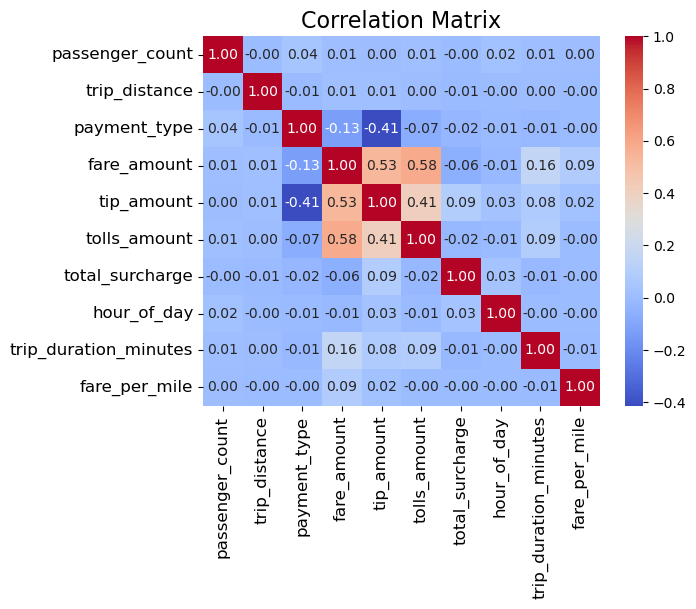

In [880]:
corr_matrix = data[['passenger_count', 'trip_distance', 'payment_type', 'fare_amount', 'tip_amount','tolls_amount','total_surcharge','hour_of_day','trip_duration_minutes','fare_per_mile']].corr()

# Visualize the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})  
plt.title('Correlation Matrix', fontsize=16)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.show()

Summary of the results of correlation matrix
- Fare amount and payment type (-0.13): A slight negative relationship suggests that as fare amounts increase, the choice of payment type may shift slightly, but the correlation is weak.
- Tip amount and fare amount (0.53): A moderate positive correlation indicates that higher fare amounts generally lead to higher tip amounts.
- Tolls amount and fare amount (0.58): A moderate positive correlation suggests that higher tolls are associated with higher fare amounts.
- Payment type and tip amount (-0.41): A moderate negative correlation indicates that customers using certain payment types tend to give lower tips.
- Tolls amount and tip amount (0.41): A moderate positive correlation suggests that when tolls are higher, tips tend to be higher as well.

#### Proportion of Trips: Weekends vs Weekdays

In [881]:
weekend_counts = data['is_weekend'].value_counts()

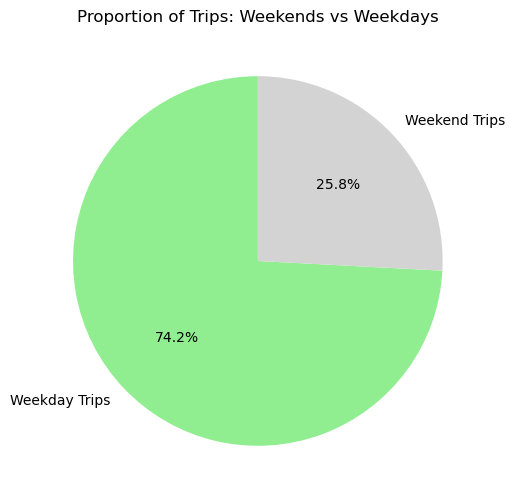

In [884]:
# Map labels for clarity
labels = ['Weekday Trips', 'Weekend Trips']

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(weekend_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightgrey'])
plt.title('Proportion of Trips: Weekends vs Weekdays')
plt.show()

The pie chart shows that 25.8% of trips occur on weekends (when weekend = 1), while 74.2% occur on weekdays (when weekend = 0). This means the majority of trips are taken during weekdays, and fewer trips are made during the weekends.

#### Average Amount by Hour of Day

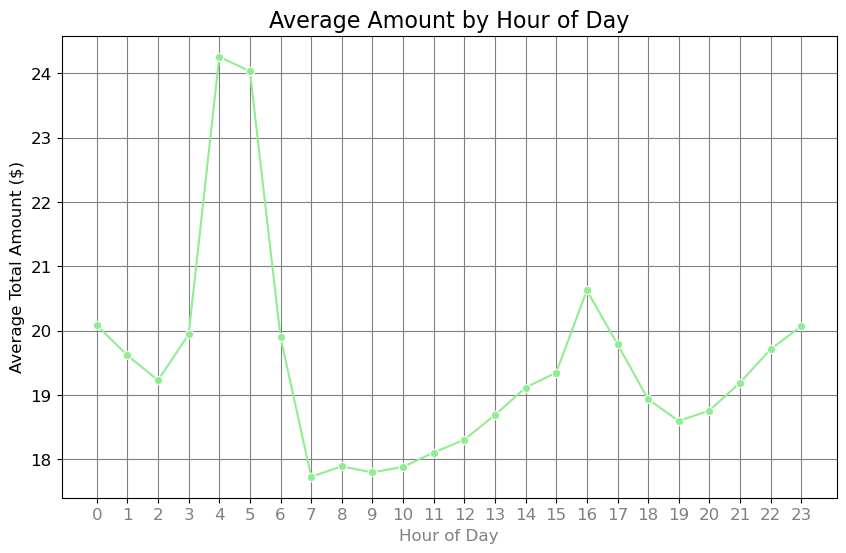

In [886]:
hourly_avg = data.groupby('hour_of_day')['total_amount'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour_of_day', y='total_amount', data=hourly_avg, marker='o', color='#90EE90')  
plt.title('Average Amount by Hour of Day', fontsize=16, color='black')  
plt.xlabel('Hour of Day', fontsize=12, color='grey')  
plt.ylabel('Average Total Amount ($)', fontsize=12, color='black')
plt.xticks(range(24), fontsize=12, color='grey')  
plt.yticks(fontsize=12, color='black') 
plt.grid(True, color='grey')  
plt.show()

The most expensive rides happen in between 04:00am and 05:00am, after that the prices increase during 16:00pm and starting from 21:00pm.

#### Total Fare Amount by Month vs Number of Trips by Month

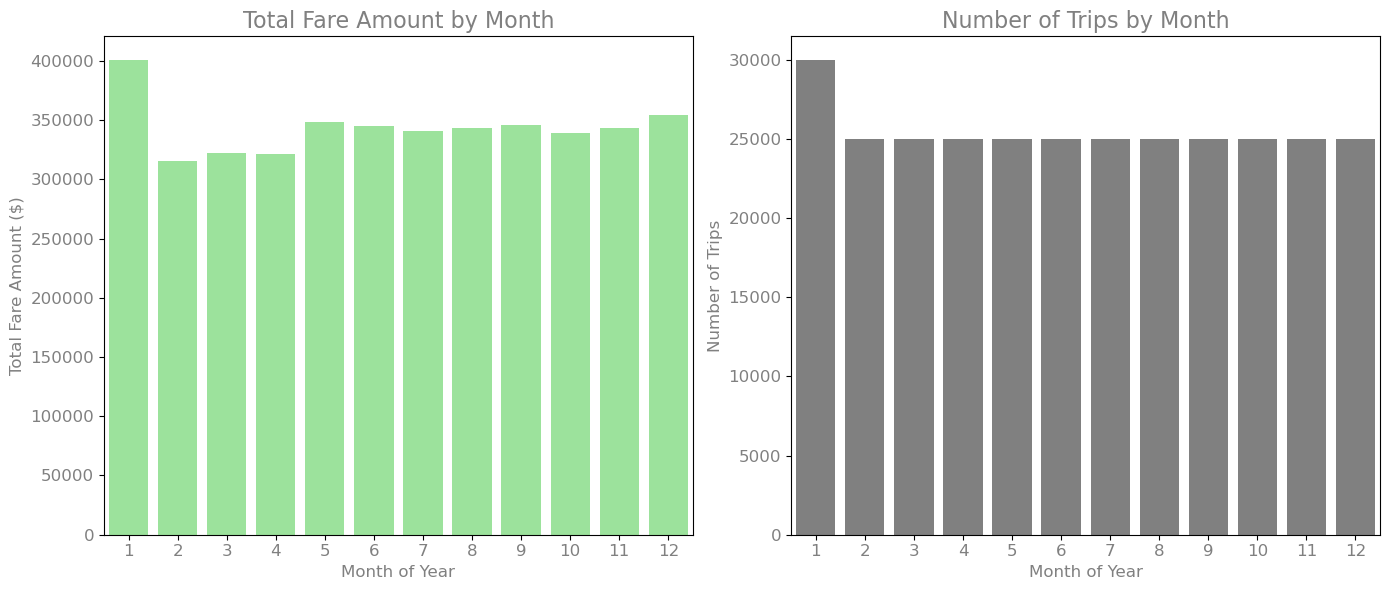

In [890]:
# Calculate total fare amount and number of trips by month
monthly_stats = data.groupby('month_of_year').agg(
    total_fare_amount=('fare_amount', 'sum'),
    num_trips=('fare_amount', 'size')  
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot total fare amount by month
sns.barplot(x='month_of_year', y='total_fare_amount', data=monthly_stats, color='#90EE90', ax=axes[0])
axes[0].set_title('Total Fare Amount by Month', fontsize=16, color='grey')
axes[0].set_xlabel('Month of Year', fontsize=12, color='grey')
axes[0].set_ylabel('Total Fare Amount ($)', fontsize=12, color='grey')
axes[0].tick_params(axis='x', labelsize=12, labelcolor='grey')
axes[0].tick_params(axis='y', labelsize=12, labelcolor='grey')

# Plot number of trips by month
sns.barplot(x='month_of_year', y='num_trips', data=monthly_stats, color='grey', ax=axes[1])
axes[1].set_title('Number of Trips by Month', fontsize=16, color='grey')
axes[1].set_xlabel('Month of Year', fontsize=12, color='grey')
axes[1].set_ylabel('Number of Trips', fontsize=12, color='grey')
axes[1].tick_params(axis='x', labelsize=12, labelcolor='grey')
axes[1].tick_params(axis='y', labelsize=12, labelcolor='grey')

plt.tight_layout()

plt.show()

Data seems to be specifically filled in. Aside from January other months have the same amount of rides, which is not likely to happen in real life. Total fare amount by month shows January as the most profitable month.

#### Average Trip Distance: Weekdays vs Weekends

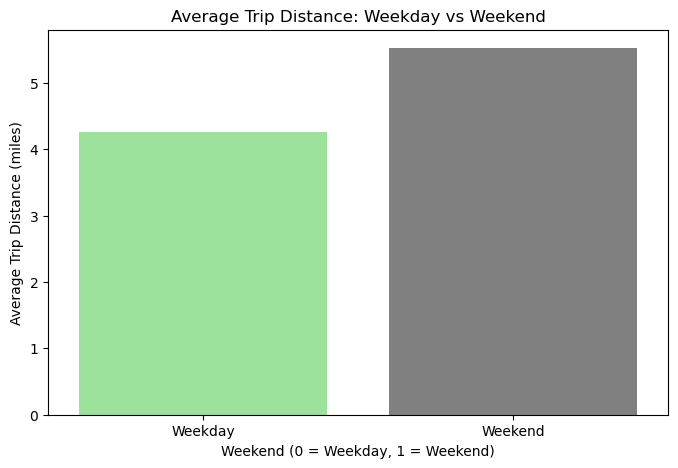

In [892]:
weekend_avg_trip_distance = data.groupby('is_weekend')['trip_distance'].mean().reset_index()

# Plot the average trip distance for weekdays vs weekends
plt.figure(figsize=(8, 5))
sns.barplot(x='is_weekend', y='trip_distance', data=weekend_avg_trip_distance, palette=['lightgreen', 'grey'])
plt.title('Average Trip Distance: Weekday vs Weekend')
plt.xlabel('Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Average Trip Distance (miles)')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

Trips taken on weekends tend to be longer than those on weekdays. This suggests that people may travel farther or take longer trips during their weekend activities, possibly due to leisure travel or trips that involve more stops or destinations. In contrast, weekday trips might be more routine and shorter, reflecting daily commutes or other time-sensitive activities. This difference in trip distance could be useful for understanding customer behavior and optimizing service offerings.

#### Average Trip Distance by Hour of Day

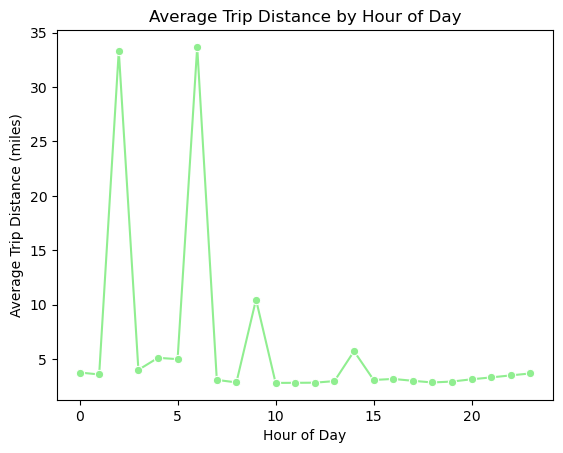

In [894]:
# Average Trip Distance by Hour of Day
hourly_trip_avg = data.groupby('hour_of_day')['trip_distance'].mean().reset_index()

sns.lineplot(x='hour_of_day', y='trip_distance', data=hourly_trip_avg, marker='o', color='lightgreen')
plt.title('Average Trip Distance by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Distance (miles)')
plt.show()

The analysis of average trip distances by hour of the day shows that the highest trip distances occur during 01:00-03:00, 07:00-08:00, and 09:00. The peak in the early morning hours (01:00-03:00) could be attributed to late-night or early-morning travel, where people might be returning from social activities or airports, often requiring longer trips. The spikes during 07:00-08:00 and 09:00 align with typical commuting hours, where individuals may travel longer distances to reach work or other destinations during peak travel times. 

### <a name="forecast"></a>3) 2023 Forecast

### <a name="revenue"></a>a) Forecast on total amount/revenue growth

In [640]:
# Extract the year and month from the pickup datetime
data['year'] = data['tpep_pickup_datetime'].dt.year
data['month'] = data['tpep_pickup_datetime'].dt.month

# Group by year and month, and calculate total fare
monthly_fare = data.groupby(['year', 'month'])['total_amount'].sum().reset_index()

# Calculate YoY growth for total fare
monthly_fare['previous_year_fare'] = monthly_fare.groupby('month')['total_amount'].shift(1)
monthly_fare['YoY_growth'] = (monthly_fare['total_amount'] - monthly_fare['previous_year_fare']) / monthly_fare['previous_year_fare'] * 100

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Prevent wrapping of the display
pd.set_option('display.max_colwidth', None)  # Display full content of each column

# Display the resulting DataFrame with YoY growth
print(monthly_fare[['year', 'month', 'total_amount', 'YoY_growth']])

    year  month  total_amount  YoY_growth
0   2018      1      77207.47         NaN
1   2018      2      78514.07         NaN
2   2018      3      80579.89         NaN
3   2018      4      80467.74         NaN
4   2018      5      87354.09         NaN
5   2018      6      83893.48         NaN
6   2018      7      83219.23         NaN
7   2018      8      82183.25         NaN
8   2018      9      84311.02         NaN
9   2018     10      85017.83         NaN
10  2018     11      84700.18         NaN
11  2018     12      83353.87         NaN
12  2019      1      75766.66   -1.866154
13  2019      2      93546.03   19.145562
14  2019      3      96432.83   19.673569
15  2019      4      97143.35   20.723348
16  2019      5      98932.25   13.254285
17  2019      6     100283.09   19.536214
18  2019      7      97484.86   17.142228
19  2019      8     100517.65   22.309169
20  2019      9      98888.15   17.289709
21  2019     10      97392.60   14.555500
22  2019     11      98297.19   16

In [642]:
train_data = monthly_fare[(monthly_fare['year'] >= 2021) & (monthly_fare['year'] < 2023)]

In [644]:
# Extract features (month and year) and target (YoY growth)
X = train_data[['year', 'month']]  # Features (Year and Month)
y = train_data['total_amount']  # Target (YoY growth)

In [646]:
# Initialize the model and fit it to the data
model = LinearRegression()
model.fit(X, y)

# Predict the YoY growth for 2023
predict_data = pd.DataFrame({
    'year': [2023] * 12,  # For each month in 2023
    'month': list(range(1, 13))  # Months from January to December
})

In [648]:
# Make predictions for 2023
predict_data['predicted_total_amount'] = model.predict(predict_data[['year', 'month']])

# Display the predictions for 2023
print(predict_data)

    year  month  predicted_total_amount
0   2023      1           108914.903622
1   2023      2           110770.016751
2   2023      3           112625.129881
3   2023      4           114480.243010
4   2023      5           116335.356139
5   2023      6           118190.469269
6   2023      7           120045.582398
7   2023      8           121900.695527
8   2023      9           123755.808657
9   2023     10           125610.921786
10  2023     11           127466.034916
11  2023     12           129321.148045


Since we have the predicted value as well as actual value for Jan 2023, we can calculate the correction factor.

In [651]:
# Actual and predicted values for January
actual_jan_value = 133677.36
predicted_jan_value = 108914.903622

# Calculate the correction factor
correction_factor = actual_jan_value / predicted_jan_value

# Apply the correction factor to all predicted values
predict_data['corrected_total_amount'] = predict_data['predicted_total_amount'] * correction_factor

# Display the corrected predictions
print(predict_data)

    year  month  predicted_total_amount  corrected_total_amount
0   2023      1           108914.903622           133677.360000
1   2023      2           110770.016751           135954.244222
2   2023      3           112625.129881           138231.128444
3   2023      4           114480.243010           140508.012667
4   2023      5           116335.356139           142784.896889
5   2023      6           118190.469269           145061.781111
6   2023      7           120045.582398           147338.665334
7   2023      8           121900.695527           149615.549556
8   2023      9           123755.808657           151892.433779
9   2023     10           125610.921786           154169.318001
10  2023     11           127466.034916           156446.202223
11  2023     12           129321.148045           158723.086446


In [653]:
# Drop the 'predicted_total_amount' column
predict_data.drop(columns=['predicted_total_amount'], inplace=True)

# Rename 'corrected_total_amount' to 'total_amount'
predict_data.rename(columns={'corrected_total_amount': 'total_amount'}, inplace=True)


# Display the updated dataframe
print(predict_data)

    year  month   total_amount
0   2023      1  133677.360000
1   2023      2  135954.244222
2   2023      3  138231.128444
3   2023      4  140508.012667
4   2023      5  142784.896889
5   2023      6  145061.781111
6   2023      7  147338.665334
7   2023      8  149615.549556
8   2023      9  151892.433779
9   2023     10  154169.318001
10  2023     11  156446.202223
11  2023     12  158723.086446


In [655]:
# Ensure both DataFrames have the same structure
predict_data['year'] = 2023  # Already exists in predict_data
predict_data['month'] = predict_data['month']  # Ensure months are present
predict_data = predict_data[['year', 'month', 'total_amount']]  # Keep consistent columns

# Concatenate the two DataFrames
monthly_fare_updated = pd.concat([monthly_fare, predict_data], ignore_index=True)

# Sort the data by year and month for a cleaner view
monthly_fare_updated = monthly_fare_updated.sort_values(by=['year', 'month']).reset_index(drop=True)

print(monthly_fare_updated)


    year  month   total_amount  previous_year_fare  YoY_growth
0   2018      1   77207.470000                 NaN         NaN
1   2018      2   78514.070000                 NaN         NaN
2   2018      3   80579.890000                 NaN         NaN
3   2018      4   80467.740000                 NaN         NaN
4   2018      5   87354.090000                 NaN         NaN
5   2018      6   83893.480000                 NaN         NaN
6   2018      7   83219.230000                 NaN         NaN
7   2018      8   82183.250000                 NaN         NaN
8   2018      9   84311.020000                 NaN         NaN
9   2018     10   85017.830000                 NaN         NaN
10  2018     11   84700.180000                 NaN         NaN
11  2018     12   83353.870000                 NaN         NaN
12  2019      1   75766.660000            77207.47   -1.866154
13  2019      2   93546.030000            78514.07   19.145562
14  2019      3   96432.830000            80579.89   19

In [657]:
# Remove duplicate rows for the same year and month (keeping the first occurrence)
monthly_fare_updated = monthly_fare_updated.drop_duplicates(subset=['year', 'month'], keep='first')

# Fill 'previous_year_fare' by shifting 'total_amount' by 12 rows (1 year)
monthly_fare_updated['previous_year_fare'] = monthly_fare_updated['total_amount'].shift(12)

# Calculate 'YoY_growth' where data is available
monthly_fare_updated['YoY_growth'] = (
    (monthly_fare_updated['total_amount'] - monthly_fare_updated['previous_year_fare'])
    / monthly_fare_updated['previous_year_fare']
) * 100

print(monthly_fare_updated)

    year  month   total_amount  previous_year_fare  YoY_growth
0   2018      1   77207.470000                 NaN         NaN
1   2018      2   78514.070000                 NaN         NaN
2   2018      3   80579.890000                 NaN         NaN
3   2018      4   80467.740000                 NaN         NaN
4   2018      5   87354.090000                 NaN         NaN
5   2018      6   83893.480000                 NaN         NaN
6   2018      7   83219.230000                 NaN         NaN
7   2018      8   82183.250000                 NaN         NaN
8   2018      9   84311.020000                 NaN         NaN
9   2018     10   85017.830000                 NaN         NaN
10  2018     11   84700.180000                 NaN         NaN
11  2018     12   83353.870000                 NaN         NaN
12  2019      1   75766.660000            77207.47   -1.866154
13  2019      2   93546.030000            78514.07   19.145562
14  2019      3   96432.830000            80579.89   19

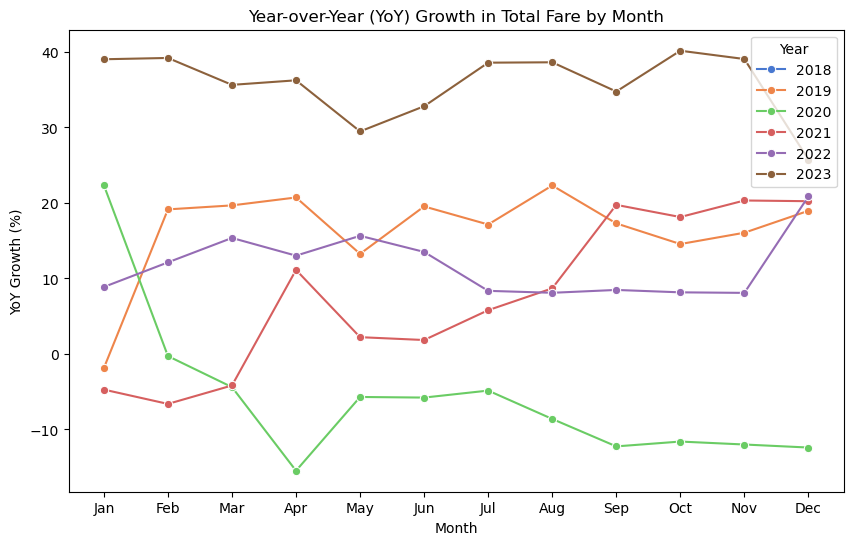

In [659]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_fare_updated, x='month', y='YoY_growth', hue='year', marker='o', palette='muted')
plt.title('Year-over-Year (YoY) Growth in Total Fare by Month')
plt.xlabel('Month')
plt.ylabel('YoY Growth (%)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

Although companies typically perform forecasting before the year begins, the data provided included the actual January value. Therefore, the forecasting was carried out using linear regression based on historical trends. Following that, a correction factor was calculated using the actual January value, and Year-over-Year (YoY) growth was subsequently computed.

As we observe, there is a noticeable decrease in YoY growth between November and December. This drop could be due to various factors, such as seasonal variations in demand, changes in consumer behavior during the holiday season, or even operational adjustments that may occur at the end of the fiscal year. Additionally, December tends to be a month where businesses experience fluctuations in activity due to the holidays, which may lead to a temporary decline.

### <a name="seasonality"></a>b) Seasonality

In [663]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_minutes,hour_of_day,day_of_week,is_weekend,month_of_year,fare_per_mile,tip_percentage,total_surcharge,trip_distance_binned,traffic_indicator,year,month
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,0.0,0.0,2.066667,12,0,0,1,6.603774,36.857143,0.3,Short,0,2018,1
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,0.0,0.0,4.683333,12,0,0,1,5.714286,17.000000,0.3,Medium,0,2018,1
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,0.0,0.0,11.066667,1,0,0,1,5.191257,17.052632,0.3,Medium,0,2018,1
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,0.0,0.0,9.766667,8,0,0,1,4.347826,0.000000,0.3,Medium,0,2018,1
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,0.0,0.0,13.950000,1,0,0,1,4.084967,8.000000,0.3,Medium,0,2018,1


In [665]:
data_21_22 = data[(data['year'] == 2021) | (data['year'] == 2022)]
monthly_trip_count = data_21_22.groupby(['year', 'month']).size().reset_index(name='trip_count')

In [667]:
monthly_trip_count

,year,month,trip_count
0,2021,1,5000
1,2021,2,5000
2,2021,3,4997
3,2021,4,5002
4,2021,5,5000
5,2021,6,5001
6,2021,7,5000
7,2021,8,4996
8,2021,9,5001
9,2021,10,5001


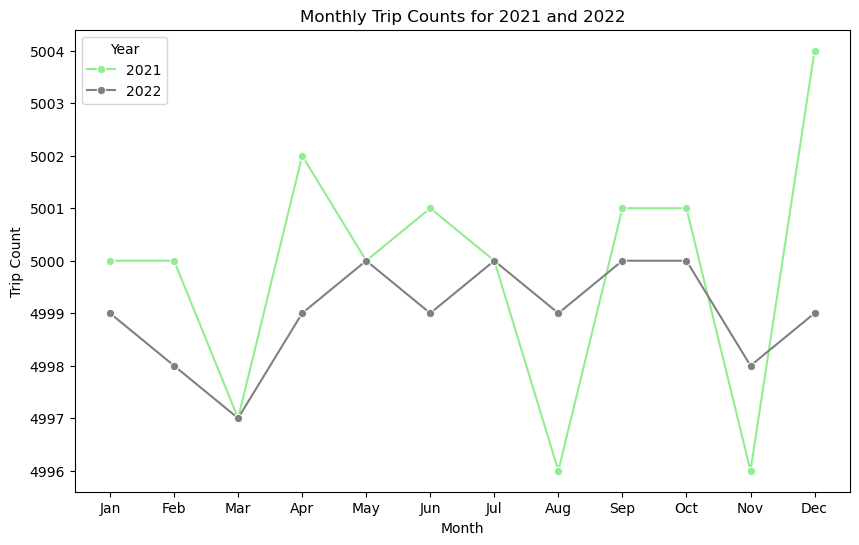

In [901]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trip_count, x='month', y='trip_count', hue='year', marker='o', palette=['lightgreen', 'grey'])

# Add title and labels
plt.title('Monthly Trip Counts for 2021 and 2022')
plt.xlabel('Month')
plt.ylabel('Trip Count')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')

plt.show()

It seems that there is no significant seasonality present in the data, as both years exhibit similar numbers across months, indicating that either the data was artificially populated or any seasonal fluctuations were likely accounted for in the dataset. 

### <a name="tips"></a>c) Happy tips, perheps?

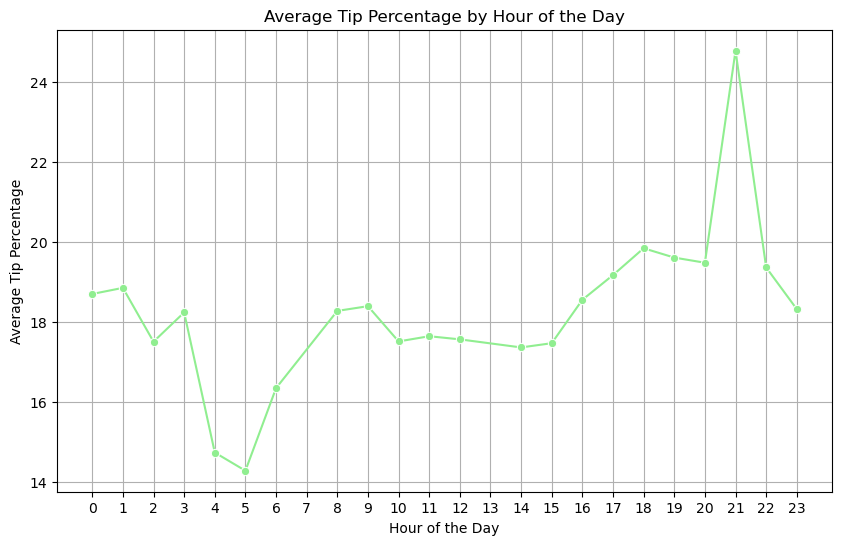

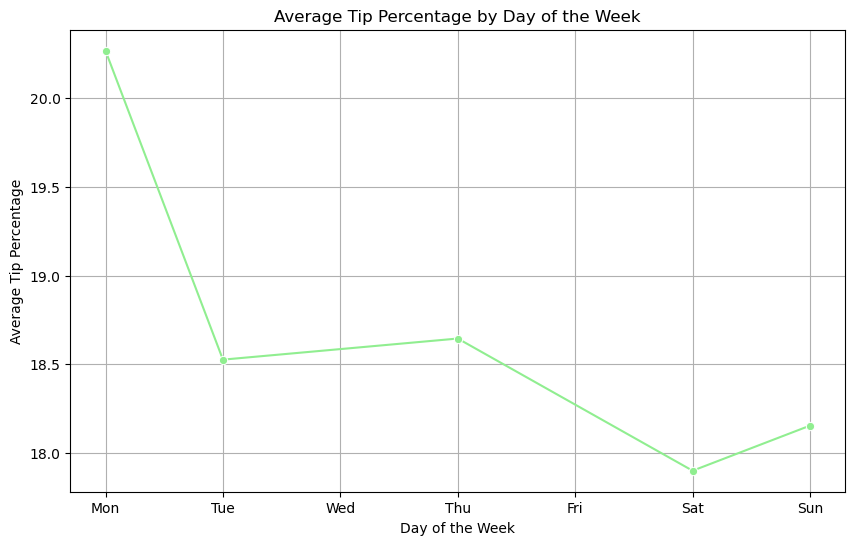

In [907]:
hourly_tip_percentage = data.groupby('hour_of_day')['tip_percentage'].mean().reset_index()

daily_tip_percentage = data.groupby('day_of_week')['tip_percentage'].mean().reset_index()

# Visualizing the average tip percentage by hour
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_tip_percentage, x='hour_of_day', y='tip_percentage', marker='o', color='lightgreen')
plt.title('Average Tip Percentage by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tip Percentage')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Visualizing the average tip percentage by day of the week
plt.figure(figsize=(10, 6))
sns.lineplot(data=daily_tip_percentage, x='day_of_week', y='tip_percentage', marker='o', color='lightgreen')
plt.title('Average Tip Percentage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Tip Percentage')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

I thought it would be a fun idea to analyze the tipping behavior throughout different hours of the day and days of the week. Interestingly, the highest tips are given between 6:00 PM and 10:00 PM, which could correlate with peak evening hours when people are likely to be dining out or engaged in other activities that might encourage larger tips 🍸 . Additionally, the highest tipping days are Mondays and Thursdays, which may reflect a variety of factors such as customers being more willing to tip generously after the weekend or due to mid-week work-related outings.

### <a name="summary"></a>4) Management Summary

This report provides an analysis of various aspects of trip data, including fare amounts, tips, trip distances, and customer behavior. The key findings and insights are summarized below.

Correlation Matrix Insights:

- Fare amount and payment type (-0.13): A weak negative correlation suggests a slight shift in payment method as fare amounts increase. However, this relationship is not strong enough to warrant significant changes in payment strategies based on fare amounts.
- Tip amount and fare amount (0.53): A moderate positive correlation indicates that higher fare amounts tend to result in higher tip amounts. This is an important insight for businesses, as it suggests that pricing adjustments could potentially influence tipping behavior.
- Tolls amount and fare amount (0.58): A moderate positive correlation indicates that higher toll amounts are associated with higher fare amounts, further emphasizing the need to consider tolls in pricing strategies.
- Payment type and tip amount (-0.41): A moderate negative correlation shows that customers using certain payment methods tend to tip less. This may suggest that businesses should encourage tips through more favorable payment options.
- Tolls amount and tip amount (0.41): A moderate positive correlation suggests that higher tolls are linked to higher tip amounts, which may imply that customers who experience higher travel costs tend to leave larger tips.

Trip Distribution:

The pie chart reveals that 74.2% of trips occur on weekdays, while only 25.8% of trips occur on weekends. This highlights that weekdays are significantly busier than weekends, which may influence pricing, staffing, and operational strategies.

Trip Pricing and Trends:

The most expensive trips occur between 04:00 AM and 05:00 AM, followed by increases during 4:00 PM to 5:00 PM and again at 9:00 PM. These price peaks align with typical travel times, suggesting that demand and pricing are influenced by time-of-day factors.
Data shows some artificial filling of trip records, particularly in months other than January. This could indicate potential inaccuracies or adjustments made to the dataset, which may impact forecasting and trend analysis.

Weekend vs Weekday Trip Behavior:

Weekend trips are generally longer than weekday trips, indicating that customers may engage in leisure travel or take trips involving multiple destinations during weekends. Weekday trips, on the other hand, are likely shorter and more routine, possibly reflecting daily commuting. This insight could inform service optimization and strategic planning for weekend operations.

Trip Distance Analysis:

The average trip distance analysis reveals that the longest trips typically occur between 01:00 AM to 03:00 AM, 07:00 AM to 08:00 AM, and 09:00 AM. The early morning hours (01:00 AM - 03:00 AM) could be attributed to late-night or early-morning travelers returning from social activities, while the 07:00 AM - 09:00 AM period corresponds with peak commuting times.
Year-over-Year (YoY) Growth Analysis:

The YoY growth analysis showed a decline between November and December. This could be attributed to seasonal fluctuations, holiday behavior, or operational adjustments towards the end of the fiscal year. The data suggests that companies should factor in such potential declines when forecasting.
Interestingly, there is no significant seasonality in the data, as the numbers across both years appear relatively similar, indicating that any seasonal variations may have been accounted for or the data may have been artificially populated.

Tipping Behavior:

The tipping analysis revealed that the highest tips are given between 6:00 PM and 10:00 PM, which likely corresponds with evening dining or social activities that encourage larger tips. Additionally, Mondays and Thursdays emerge as the highest tipping days, which may reflect customers’ willingness to tip generously after the weekend or due to mid-week work-related outings.

Conclusion:
The analysis provides valuable insights into customer behavior, trip patterns, and revenue trends, helping businesses understand where to focus their operational strategies. For example, higher fares are linked with higher tips, so the companies could use this data to optimize their dynamic pricing models and payment options. Additionally, the trends in trip distances and times can guide resource allocation, while tipping patterns suggest the need for strategic marketing or staffing adjustments during peak tipping periods. Understanding these patterns will help companies improve efficiency, maximize revenue, and enhance customer satisfaction.